<font size=6.5><center> Deep ConvNets in Ophthalmology: A Retinal Features-based Approach for Automated Eye Cancers Identification</center>

<font size=3.5> <center> Rimsha Saeed - Abdullah Sajid - Muhammad Usama </font>

## Overview
The goal is to make an optimal ocular disorders identification model. We retrieved 26 categories of 1500 true-colour fundus images in 24-bit RGB format from 8 open-access databases, namely:

- STARE – STructured Analysis of the Retina
- DRIVE – Digital Retinal Images for Vessel Extraction
- Messidor (base11) – Methods to Evaluate Segmentation and Indexing Techniques in the field of Retinal Ophthalmology
- Kaggle – 1000 Fundus Images
- Kaggle – Glaucoma Detection
- DRHAGIS – Diabetic Retinopathy, Hypertension, Age-related macular degeneration, and Glaucoma ImageS
- HRF – High-Resolution Fundus
- GitHub – Retina Dataset

## Import required packages

In [1]:
import cv2
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from keras import regularizers
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import models
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Import Dataset

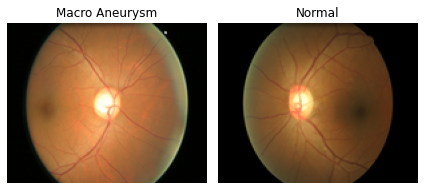

In [2]:
# Defina a function to import images, their classes and output labels
def Dataset(filename):
    """
    Reads dataset from a csv file into DataFrame.
    Assigns numeric labels to each class using LabelEncoder()
    
    Arguments: None
    Returns: Dataframe - 1500 fundus images, their classes and labels
    
    """
    with open(filename) as dataset:
        data = pd.read_csv(dataset)
        
        # Read content from data['Images']
        img = data.iloc[:,0]
        
        # Read and resize the images
        X = []
        size = [150,120]
        for i in range(img.shape[0]):
            I = Image.open(img[i])
            I = I.resize(size, Image.ANTIALIAS)
            X.append(I)
        
        # Pack image arrays in dataframe
        data['Images'] = X
        
        # Convert string Class labels to numeric
        en = LabelEncoder()
        data['Labels'] = en.fit_transform(data['Classes'].values)
                
        return data

# Import data
df = Dataset('dataset.csv')

# Display random examples
fig = plt.figure()
for i in range(1,3):
    random.seed(i)
    ax = fig.add_subplot(1,2,i)
    ax.imshow(df['Images'][random.randint(1,len(df))])
    ax.set_title(df['Classes'][random.randint(1,len(df))])
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Preprocessing

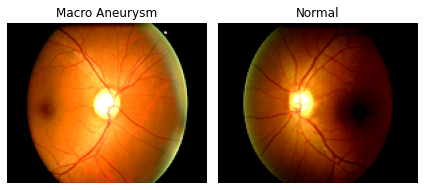

In [3]:
# Define a function to enhance contrast of fundus images
def enhance_contrast(img, contrast):
    """
    Enhances the contrast of fundus images
    Increases the visibility of retinal vessels
    
    Arguments: img - RGB image
    Returns: enhanced_img - Contrast enhanced RGB image
    
    """    
    alpha_c = 131*(contrast + 127)/(127*(131-contrast))
    gamma_c = 127*(1-alpha_c)
    enhanced_img = cv2.addWeighted(img, alpha_c, img, 0, gamma_c)
    
    return enhanced_img

# Define a function to obtain 31x31 Gabor Kernels
def Gabor_Filters():
    """
    The Gabor filter is a linear filter whose kernel is a 2D Gaussian modulated with a cosine wave.
    Useful in detecting edges of known orientation.
    
    Arguments: None
    Returns: filters - 31x31 Gabor filters
    
    """
    filters = []
    for t in np.arange(0, np.pi, np.pi / 20):
        kernels = cv2.getGaborKernel((31, 31),
                                     sigma = 5,
                                     theta = t,
                                     lambd = 12,
                                     gamma = 0.6,
                                     psi = 0,
                                     ktype = cv2.CV_32F)
        kernels /= 1.5*kernels.sum()
        filters.append(kernels)
    
    return filters

# Define a function to implement morphological opening and closing alternatively
def morphological_operations(I):
    """
    Opening removes small objects/bright pixels from the foreground and places them in the background.
    Closing removes small holes in the foreground and changes small islands of background into foreground.
    
    Arguments: I - 2D image
    Returns: I - 2D image after morphological opening and closing
    
    """
    I = cv2.morphologyEx(I, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=1)
    I = cv2.morphologyEx(I, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=1)
    I = cv2.morphologyEx(I, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)), iterations=1)
    I = cv2.morphologyEx(I, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)), iterations=1)
    I = cv2.morphologyEx(I, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23, 23)), iterations=1)
    I = cv2.morphologyEx(I, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23, 23)), iterations=1)
    
    return I

# Define a function to process the images
def preprocess(df):
    """
    Implements certain image processing techniques on fundus images 
    
    Arguments: df - ['Images','Classes', 'Labels']
    Returns: df - ['Processed Images','Classes', 'Labels']
    
    """
    X = []
    filters = Gabor_Filters()
    for i in range(len(df)):
        I = np.array(df['Images'][i])
        
        # Enlarge the images
        I = cv2.resize(I, dsize=(1200, 1024))
        
        # Enhance image contrast
        I = enhance_contrast(I, contrast = 40)
        
        # Extract image channels
        r, g, b = cv2.split(I)
        
        # Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit = 4.0, tileGridSize = (16, 16))
        
        # Apply CLAHE to green-channel
        g_eq = clahe.apply(g)
        
        # Apply morphological opening and closing alternatively
        g_eq_m = morphological_operations(g_eq)
        vessels = cv2.subtract(g_eq_m, g_eq)
        
        # Combine the planes
        I = cv2.merge([r, vessels, b])
        
        # Apply CLAHE 
        I = clahe.apply(I)
        
        # Apply Gabor Filters
        I = np.array([cv2.filter2D(I, -1, k) for k in filters])
        I = np.max(I, 0)
        
        # Restore original size
        I = cv2.resize(I/255, dsize = df['Images'][i].size)
        
        X.append(I)
    
    df['Images'] = X
    
    return df

# Apply image processing
df = preprocess(df)

# Display random examples after preprocessing
fig = plt.figure()
for i in range(1,3):
    random.seed(i)
    ax = fig.add_subplot(1,2,i)
    ax.imshow(df['Images'][random.randint(1,len(df))], cmap ='gray')
    ax.set_title(df['Classes'][random.randint(1,len(df))])
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Visualize Class Distribution

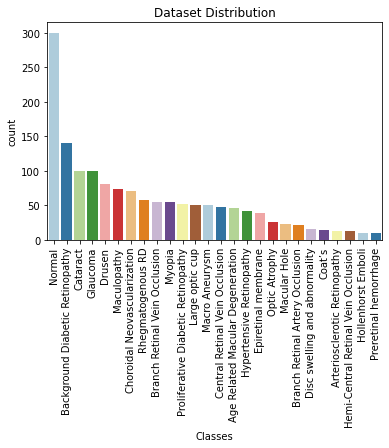

In [4]:
# Define a function to visualize number of fundus images available per class
def class_distribution(df):
    """
    Shows the count of images in each class using bars
        
    Arguments: df - ['Images','Classes', 'Labels']
    Returns: Bar graph representing the class distribution
    
    """
    p = sns.countplot(x="Classes", data=df, palette='Paired')
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    plt.title('Dataset Distribution')
    plt.show()
    
    return

# Visualize dataset distribution
class_distribution(df)

The dataset is highly imbalanced with 300 images for Normal fundus and only 10 images for preretinal hemorrhage.

## Test-train Split  <font size=3> (Along with randoming sampling of Training set) </font>
Dataset is split into:
- 70% Training set
- 15% Validation set
- 15% Test set

After splitting the dataset, Random Sampling method is applied to training examples. It will replicate the images in minority classes resuling in balanced distribution per class. However, the number of images in test and validation sets will not be affected.

In [5]:
# Create function to split dataset into Training and Validation set
def split_dataset(df, testSize):
    """
    Splits dataset into Train and Test sets randomly
        
    Arguments: df - ['Images','Classes', 'Labels']
               testSize - If float, should be between 0.0 and 1.0 and 
                          represent the proportion of the dataset to 
                          include in the test split. If int, represents 
                          the absolute number of test samples. 
    Returns: X_train - ndarray of images in training set
             X_test - ndarray of images in test set
             y_train - categorical labels for training set
             y_test -  categorical labels for test set
    
    """
    X = df['Images'].tolist()
    y = df['Labels'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = testSize, 
                                                        random_state = 394, 
                                                        shuffle = True, 
                                                        stratify = y)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      test_size = testSize + 0.05, 
                                                      random_state = 394, 
                                                      shuffle = True, 
                                                      stratify = y_train)
    
    # Define a function to balance training set
    def balance_data(X, y):
        """
        Removes imbalance from training set by random sampling method.
        
        Arguments: df - ['Images','Classes', 'Labels']
        Returns: X - List of randomly sampled training images
                 y - List of labels corresponding to each image in X
        """
        # Get number of samples in majority class
        class_size = max(Counter(y).values())
        df = pd.DataFrame({'Images': X, 'Labels': y})

        balanced_df = df.groupby(['Labels']).apply(
            lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)
        balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

        X = balanced_df['Images'].tolist()
        y = balanced_df['Labels'].tolist()

        return X, y

    # Resample the images in training set
    X_train, y_train = balance_data(X_train, y_train)
    
    # Transform images to numpy arrays
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    
    # Transform Labels to categorical numpy arrays
    y_train = to_categorical(y_train, num_classes = max(y_train)+1, dtype = 'int')
    y_val = to_categorical(y_val, num_classes = max(y_val)+1, dtype = 'int')
    y_test = to_categorical(y_test, num_classes = max(y_test)+1, dtype = 'int')
    
    """
    To convert back, use:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
    
    """
    
    return X_train, X_val, X_test, y_train, y_val, y_test


# Split dataset into Training and Test set
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(df, testSize=0.15)

## Visualize class distribution in Training set

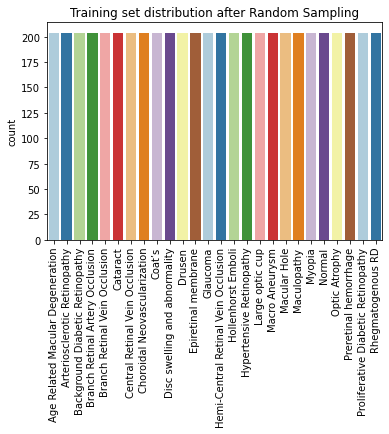

In [6]:
p = sns.countplot(x = np.argmax(y_train, axis=1), palette='Paired')
p.set_xticklabels(np.unique(df['Classes']), rotation=90)
plt.title('Training set distribution after Random Sampling')
plt.show()

Now, each class in training set has equal number of training samples. 

### Dataset details

In [7]:
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of validation examples = " + str(X_val.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

Number of training examples = 5304
Number of validation examples = 255
Number of test examples = 225
X_train shape: (5304, 120, 150, 3)
Y_train shape: (5304, 26)
X_val shape: (255, 120, 150, 3)
Y_val shape: (255, 26)
X_test shape: (225, 120, 150, 3)
Y_test shape: (225, 26)


## Image Augmentation
Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.
Training deep neural network models on more data can result in more efficient models, and the augmentation techniques can create variations of the images that can improve the ability of the models to fit or generalize what they have learned to new images.

This is achieved by using the ImageDataGenerator class from Keras_preprocessing.

In [8]:
# Define a function that initializes ImageDataGenerator
def Image_Augment():
    """
    Initializes ImageDataGenerator for image augmentation
    
    Arguments: None
    Returns: Image Data Generator
    
    """
    datagen = ImageDataGenerator(horizontal_flip = False,
                                 vertical_flip = False,
                                 zoom_range = 0,
                                 rotation_range = 0,
                                 width_shift_range = 1,
                                 height_shift_range = 1,
                                 shear_range = 0.01,
                                 fill_mode="nearest")
    
    return datagen

# Initialize the training set generator
train_datagen = Image_Augment()

### Training Classifier

In [9]:
# Define a function to create training model
def Model():
    """
    Sets up a deep convolution neural network using Keras Sequential model

    Arguments: None
    Returns: A compiled DNN classifier

    """

    # Initialize Keras Sequential Model
    model = models.Sequential()
    
    # First convolutional Layer
    model.add(layers.Conv2D(filters = 32,
                            kernel_size = (3, 3),
                            strides = (2, 2),
                            kernel_regularizer = regularizers.l2(0.01),
                            name = 'Conv_01',
                            input_shape=(120, 150, 3)))
    # Batch Normalization Layer
    model.add(layers.BatchNormalization(axis = 3, name = 'BN_01'))
    # Activation layer
    model.add(layers.Activation('relu', name = 'Activation_01'))
    
    # Second convolutional Layer
    model.add(layers.Conv2D(filters = 64,
                            kernel_size = (3, 3),
                            kernel_regularizer = regularizers.l2(0.001),
                            activation = 'relu',
                            name = 'Conv_02'))
    # Batch Normalization Layer
    model.add(layers.BatchNormalization(axis = 3, name = 'BN_02'))
    # Activation layer
    model.add(layers.Activation('relu', name = 'Activation_02'))

    # Max Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name = 'MaxPool_01'))

    # Third convolutional layer
    model.add(layers.Conv2D(filters = 16, 
                            kernel_size = (4, 4), 
                            kernel_regularizer = regularizers.l2(0.001), 
                            name = 'Conv_03'))
    model.add(layers.Dropout(0.1, name = 'Dropout_01'))
    
    # Flatten the results to feed into a DNN
    model.add(layers.Flatten())

    # 128-neuron hidden layer
    model.add(layers.Dense(128, kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001),
                           activation = 'relu', name = 'FullyConnected_01'))
    model.add(layers.Dense(26, activation='softmax', name = 'OutputLayer'))

    # Compile the model
    model.compile(optimizer='adam', loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# Initialize the model
model = Model()

# Interpret model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_01 (Conv2D)             (None, 59, 74, 32)        896       
_________________________________________________________________
BN_01 (BatchNormalization)   (None, 59, 74, 32)        128       
_________________________________________________________________
Activation_01 (Activation)   (None, 59, 74, 32)        0         
_________________________________________________________________
Conv_02 (Conv2D)             (None, 57, 72, 64)        18496     
_________________________________________________________________
BN_02 (BatchNormalization)   (None, 57, 72, 64)        256       
_________________________________________________________________
Activation_02 (Activation)   (None, 57, 72, 64)        0         
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 28, 35, 64)        0

### Training

In [10]:
# Set-up model callbacks
lr_decay = LearningRateScheduler(schedule=lambda epoch: 0.001*np.exp(-epoch/10.))
checkpoint = ModelCheckpoint('weights-{epoch:02d}val_loss-{val_loss}.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             verbose = 1)

# Training
training = model.fit(x = train_datagen.flow(X_train, y_train, batch_size = 32),
                     validation_data = (X_val, y_val),
                     max_queue_size = 2,
                     steps_per_epoch = len(y_train)/32,
                     epochs = 30,
                     callbacks = [checkpoint, lr_decay],
                     verbose = 1)

Epoch 1/30
166/165 [==============================] - ETA: 0s - loss: 11.3598 - accuracy: 0.5871
Epoch 00001: val_loss improved from inf to 7.32447, saving model to weights-01val_loss-7.324469089508057.h5
166/165 [==============================] - 130s 783ms/step - loss: 11.3598 - accuracy: 0.5871 - val_loss: 7.3245 - val_accuracy: 0.2511
Epoch 2/30
166/165 [==============================] - ETA: 0s - loss: 3.7388 - accuracy: 0.8808
Epoch 00002: val_loss improved from 7.32447 to 5.97300, saving model to weights-02val_loss-5.973002910614014.h5
166/165 [==============================] - 115s 694ms/step - loss: 3.7388 - accuracy: 0.8808 - val_loss: 5.9730 - val_accuracy: 0.5270
Epoch 3/30
166/165 [==============================] - ETA: 0s - loss: 3.6886 - accuracy: 0.9033
Epoch 00003: val_loss improved from 5.97300 to 4.35031, saving model to weights-03val_loss-4.350314140319824.h5
166/165 [==============================] - 102s 617ms/step - loss: 3.6886 - accuracy: 0.9033 - val_loss: 4.3

###  Save the trained model

In [11]:
model.save('trained_model.h5')

### Model Performance

In [12]:
score_train = model.evaluate(X_train, y_train, verbose=1)
score_val = model.evaluate(X_val, y_val, verbose=1)

print('Training Loss: ' +"{:.3f}".format(score_train[0]))
print('Training Accuracy: ' +"{:.3f}".format(score_train[1]*100) + '%')
print('Validation Loss: ' +"{:.3f}".format(score_val[0]))
print('Validation Accuracy: ' +"{:.3f}".format(score_val[1]*100) + '%')

8/8 [==============================] - 1s 65ms/step - loss: 0.2510 - accuracy: 0.9843
Training Loss: 0.247
Training Accuracy: 98.661%
Validation Loss: 0.251
Validation Accuracy: 98.431%


### Learning curves

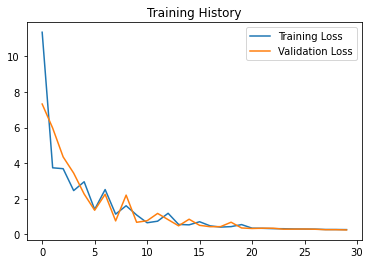

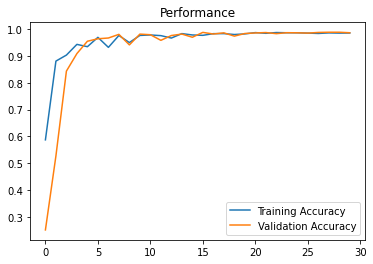

In [13]:
plt.plot(training.history['loss'], label = 'Training Loss')
plt.plot(training.history['val_loss'], label = 'Validation Loss')
plt.title('Training History')
plt.legend()
plt.show()

plt.plot(training.history['accuracy'], label = 'Training Accuracy')
plt.plot(training.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Performance')
plt.legend()
plt.show()

### Evaluation on test set

8/8 [==============================] - 1s 86ms/step
Test Accuracy: 92.94%


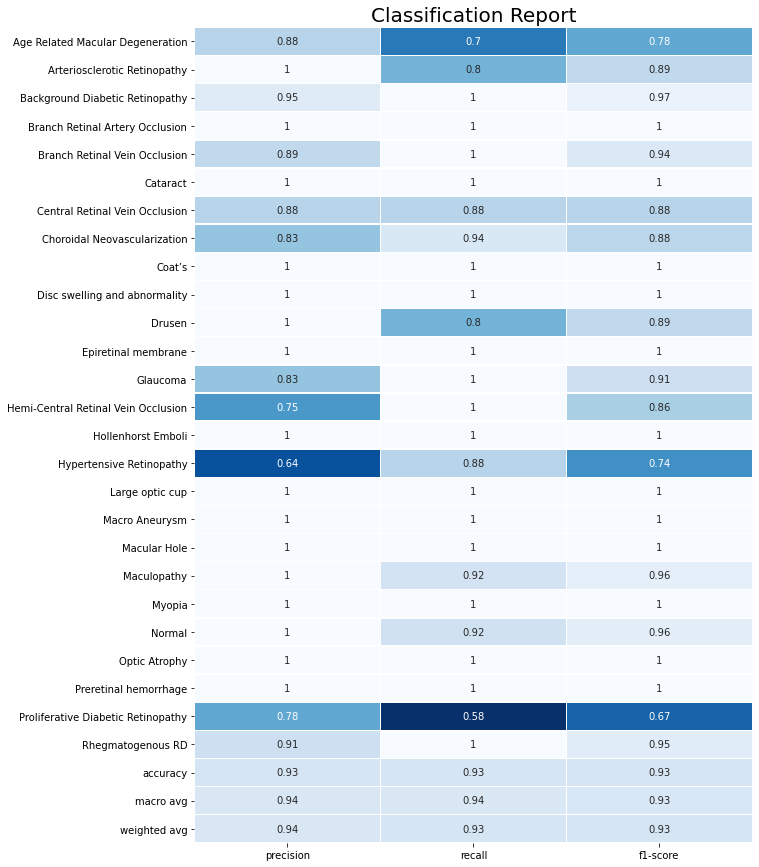

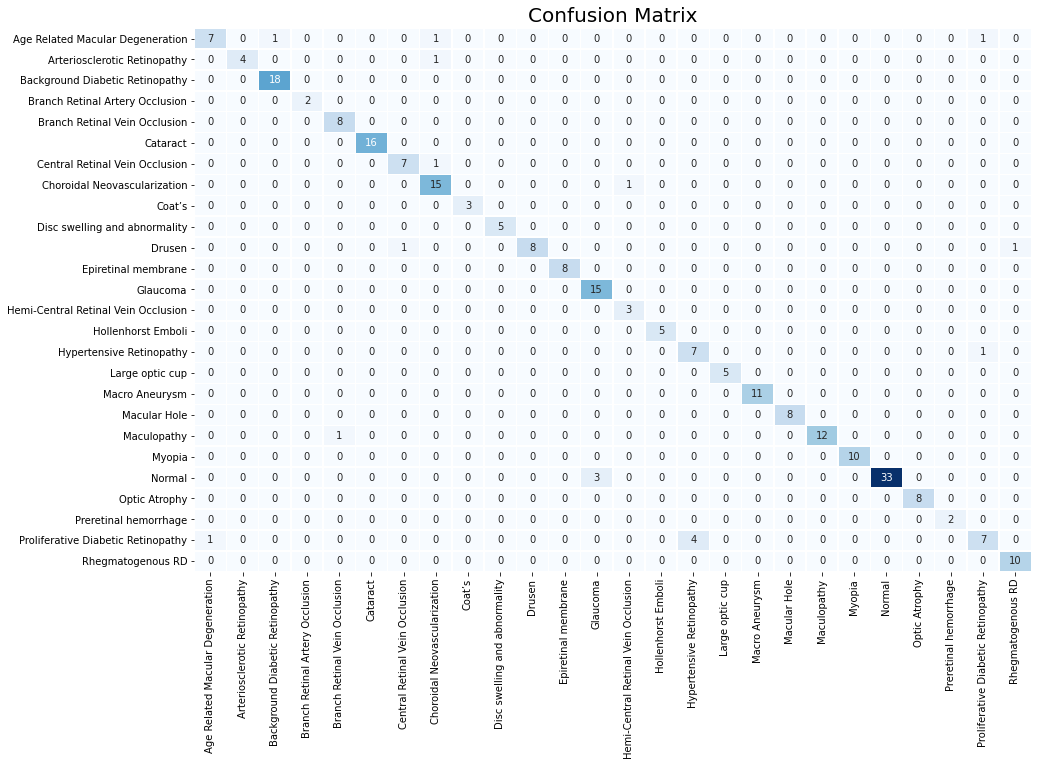

In [14]:
def Evaluation(y_true, y_pred, labels, classes):
    """
    Evaluates the model on unseen fundus images in terms of
    Accuracy, Precision, Recall, F1-score, and Confusions Matrix
    
    Arguments: y_true - Actual labels (categorical)
               y_pred - Predicted labels (categorical)
               labels - Categorical labels for each class
               classes - Fundus classes as 'string'
    Returns: Accuracy - On test set
             report - sklearn classification report
             CM - Confusion Matrix 
    
    """
    y_pred = np.argmax(y_pred, axis = 1)
    y_true = np.argmax(y_true, axis = 1)
    
    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Generate classification report
    report = classification_report(y_true, y_pred, 
                                   labels = labels,
                                   target_names = classes,
                                   output_dict = True)
    
    # Generate confusion matrix
    CM = confusion_matrix(y_true, y_pred)
    
    # Plot classification report
    """
    .iloc[:-1, :] removes 'Support' column from classification report
    
    """
    plt.figure(figsize = (10, 15))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot = True, linewidths = .5,
                xticklabels = True, yticklabels = True, cmap = 'Blues_r', cbar = False)
    plt.title('Classification Report', fontsize = 20)
    
    # Plot confusion matrix
    plt.figure(figsize = (15, 10))
    sns.heatmap(CM, annot = True, cbar = False, yticklabels = classes, linewidths = .5,
                xticklabels = classes, cmap = 'Blues')
    plt.title('Confusion Matrix', fontsize = 20)
    
    return accuracy, report, CM


# Test and evaluate the model
y_pred = model.predict(X_test, verbose = 1)
base = np.unique(df['Classes'].values)
labels = np.unique(df['Labels'].values)
Accuracy, Report, Confusion_Matrix = Evaluation(y_test, y_pred, labels, base)
print('Test Accuracy: ' + "{:.2f}".format(Accuracy*100) + '%')

### Make a random predictions

1/1 [==============================] - 0s 997us/step


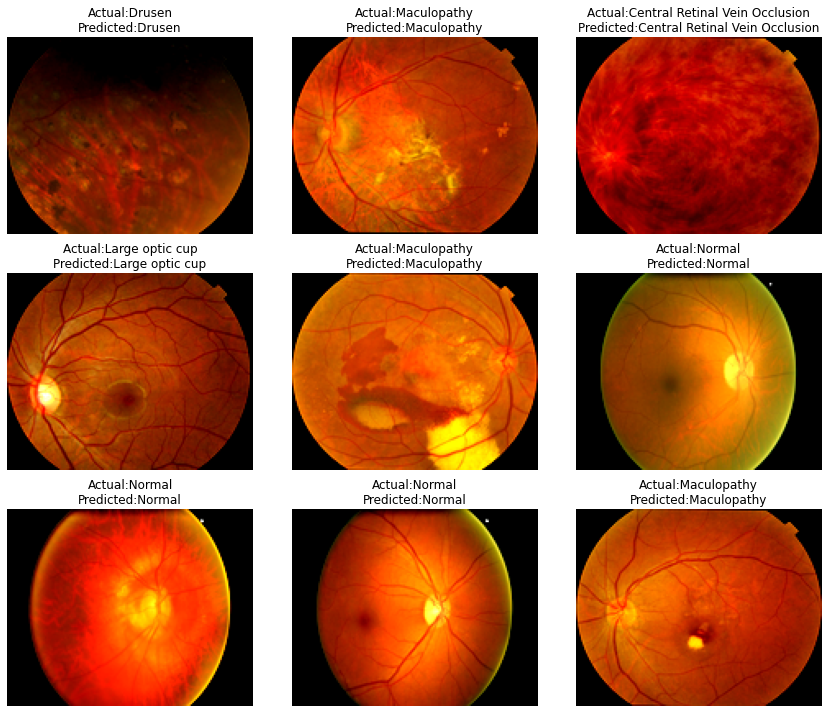

In [15]:
def Predictor(Model, Test_sample, Output, classes):
    """
    A sample function that predicts the class of ocular disorder
    based on the fed fundus image
    
    Arguments: Model - Pre-trained Keras Classifier
               Test_sample - Fundus image of size [120, 150, 3]
               Output - True label (categorical)
               classes - A list of 26 Fundus classes (string)
    Returns: pred - predicted class (string)
             true - true class (string)
             
    """
    y = Model.predict(np.expand_dims(Test_sample, axis=0), verbose = 1)
    pred = classes[np.argmax(y)]
    true = classes[np.argmax(Output)]
    
    return pred, true

fig = plt.figure(figsize = (12, 10))
for i in range(1,10):
    ax = fig.add_subplot(3,3,i)
    pred, true = Predictor(model, X_test[i], y_test[i], base)
    ax.imshow(X_test[i])
    ax.set_title('Actual:'+ true + '\n' + 'Predicted:'+ pred)
    ax.axis('off')

plt.tight_layout()
plt.show()

###### Done!